<h1>SIT307 Group Assignment 1 notebook</h1>

<h3>Group 3</h3>
<p>By:<br>
    Aaron Norwood,218330434<br>
    Joshua Anthony, 219466473<br>
    Roger Middenway, 217602784<br>
    David Adams, 216110104<br>
    Linden Hutchinson, 218384326<br>
    Dale Orders, 219106283

# Imported libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
import plotly.express as px
%matplotlib inline

<h3> Read in the data, store if dataframe

In [2]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

<h4>Tidying

In [3]:
## drop unnecessary id column
df.drop(['id'], axis=1, inplace=True)

##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

## drop the one row that has "other" gender to keep things simple
df.drop(index=df[df['gender'] == 'other'].index, inplace=True)

# replace gender with binary values
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})

# replace marital status with binary values
df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

## round off age
df['age'] = df['age'].apply(lambda x : round(x))

# cap BMI outliers to a maximum of 60 
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)



<h4>Imputing

In [4]:
m_df = df[df['gender'] == 1]
f_df = df[df['gender'] == 0]

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 1:
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]

<h4>Binning

In [5]:
# implement age bins
df['age_bin'] = pd.qcut(df['age'], q = 10, precision=1)

# implement glucose bins
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)

# implement bmi bins
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)

<h4>Add Dummies

In [6]:
def add_dummy(target_df, origin_df, col):
    abbrev = col[:2] + '_'
    for cat in origin_df[col].value_counts().index.tolist()[1:]:
        target_df[abbrev + str(cat)] = origin_df[col] == cat
        target_df[abbrev + str(cat)] = target_df[abbrev + str(cat)].map({False: 0, True: 1})


In [7]:
df_dummies = pd.DataFrame(index=df.index)

add_dummy(df_dummies, df, 'work_type')
add_dummy(df_dummies, df, 'smoking_status')
add_dummy(df_dummies, df, 'age_bin')
add_dummy(df_dummies, df, 'avg_glucose_level_bin')
add_dummy(df_dummies, df, 'bmi_bin')

In [8]:
to_add = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'stroke']
df_dummies[to_add] = df[to_add]

In [9]:
selected = ['av_(80.0, 85.6]',
'wo_self-employed',
'sm_formerly-smoked',
'ag_(38.0, 45.0]',
'ever_married',
'ag_(11.0, 20.0]',
'ag_(30.0, 38.0]',
'ag_(-0.1, 11.0]',
'ag_(20.0, 30.0]',
'bm_(29.9, 31.8]',
'wo_children',
'av_(192.2, 271.7]',
'hypertension',
'ag_(65.0, 75.0]',
'heart_disease',
'ag_(75.0, 82.0]',
 'stroke']

df_sel = df_dummies[selected]


In [10]:
import prince
mca_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'stroke', 'age_bin', 'avg_glucose_level_bin', 'bmi_bin']
df_mca = df[mca_cols]

mca = prince.MCA()
mca.fit(df_mca)
mca.transform(df_mca)

df_mixed_mca = pd.merge(df_sel, mca.row_coordinates(df_mca), left_index=True, right_index=True)

X = df_mixed_mca.drop(['stroke'], axis=1)
y = df_mixed_mca['stroke']

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from IPython.display import clear_output
import random

In [12]:
def get_random_float(min, max):
    return min + (max-min)*random.random()

def get_svc(class_weight=None, kernel="rbf", gamma='scale', shrinking=True, probability=False, break_ties=False):
    return SVC(class_weight=class_weight, kernel=kernel, gamma=gamma,shrinking=shrinking,probability=False)

def get_cv_scores(model, X, y, n_splits=5,n_repeats=10, scoring=None):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    return cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)

def run_model(model, X, y, metric="recall"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=82)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(model, X_test, y_test)
    print(classification_report(y_test, y_pred))
    
def get_metrics_score(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = {
        'recall':recall_score(y_test, y_pred, labels=np.unique(y_pred), zero_division=0),
        'f1':f1_score(y_test, y_pred, labels=np.unique(y_pred), zero_division=0),
        'roc_auc':roc_auc_score(y_test, y_pred, labels=np.unique(y_pred)),
        'precision':precision_score(y_test, y_pred, labels=np.unique(y_pred), zero_division=0),
    }
    return scores

def get_reports_score(model, X, y):
    '''
    returns the recall, f1 and precision values obtained for the "1" class in a classification report
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    scores = {
        'recall':report['1']['recall'],
        'f1':report['1']['f1-score'],
        'precision':report['1']['precision'],
    }
    return scores

def check_if_better(old, new, thres=1.2):
    '''
    divides the new value by the old value and checks to see if this is greater than a threshold
    if new/old > 1, the new value is better than the old
    if new/old < 1, the new value is worse
    By setting the threshold, you can decide how much worse than the old is acceptable for the new value
    '''
    
    if old == 0:
        return True
    if(new/old > thres):
        return True
    
    return False

## Grid Search for optimizing model metrics

In [13]:
# this was much more convoluted previously, which is why I bothered to output the remaining percentage
# as I narrowed in on the optimum parameters, I could remove loops entirely and speed up the process alot

weights = [round(get_random_float(0, 10), 1) for i in range(10)]
kernel = 'linear'
gamma = 'auto'
shrinking = 1
probability = 1

best = {
    'recall':0,
    'precision':0,
    'roc':0,
    'f1':0
}

best_cell = {}
cells = []
total_len = len(weights)
counter = 0
for w1 in weights:
    counter +=1
    
    # while testing it was found that the actual value of the weights didn't seem to matter, the important thing was the proportion of w2 to w1
    # proportions of between 2 and 3:1 gave the best all round results for metrics
    # As the proportion increases, False Negatives slightly decrease while False Positives increase significantly
    # a proportion of 20:1 will maximize recall but to the detriment of other metrics
    
    w2 = w1 * get_random_float(2,3)
    class_weight = {0: w1, 1: w2}
    svc = get_svc(class_weight = class_weight, kernel=kernel, gamma=gamma, shrinking=shrinking, probability=probability) 
    scores = get_metrics_score(svc, X, y)

    cell = {
        'w1':w1,
        'w2':w2,
        'gamma':gamma,
        'kernel':kernel,
        'recall':scores['recall'],
        'f1':scores['f1'],
        'roc_auc':scores['roc_auc'],
        'precision':scores['precision'],
        
    }
    clear_output(wait=True)
    
    # only update the best cell if
    # recall is better than the current best
    # roc_auc isn't more than 15% worse than the current best
    # precision isn't more than 15% worse than the current best
    # f1 isn't more than 10% worse than the current best
    if scores['recall'] > best['recall'] and check_if_better(best['roc'], scores['roc_auc'], 0.85) and check_if_better(best['precision'], scores['precision'], 0.85) and check_if_better(best['f1'], scores['f1'], 0.9):
        best_cell = cell
        best['recall'] = scores['recall']
        best['f1'] = scores['f1']
        best['roc'] = scores['roc_auc']
        best['precision'] = scores['precision']
        print(f"Recall score: {scores['recall']:.3f} - new best")
    else:
        print(f"Recall Score: {scores['recall']:.3f} - best recall score is {best['recall']:.3f}")
    [print(key, value, end="\n") for key, value in best_cell.items()]
    print(f"Total complete: {100*(counter/total_len):.2f}%")
    cells.append(cell)

Recall Score: 0.760 - best recall score is 0.780
w1 5.6
w2 15.910639217187713
gamma auto
kernel linear
recall 0.78
f1 0.7647058823529411
roc_auc 0.883312757201646
precision 0.75
Total complete: 100.00%


Mean cv score 0.9757877526924794
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1594
           1       0.78      0.87      0.82        92

    accuracy                           0.98      1686
   macro avg       0.89      0.93      0.91      1686
weighted avg       0.98      0.98      0.98      1686



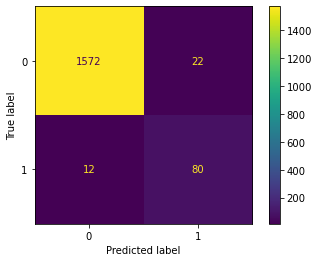

In [14]:
weight = {0: best_cell['w1'], 1: best_cell['w2']}
          
model = get_svc(weight, best_cell['kernel'], best_cell['gamma'], shrinking=shrinking, probability=probability)

cv_scores = get_cv_scores(model, X, y)
print("Mean cv score", np.mean(cv_scores))
run_model(model, X, y)

## Static Optimized SVC

Mean cv score 0.9755724310037165
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1594
           1       0.78      0.86      0.82        92

    accuracy                           0.98      1686
   macro avg       0.89      0.92      0.90      1686
weighted avg       0.98      0.98      0.98      1686



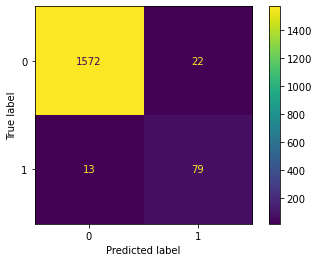

In [15]:
weight = {0: 1, 1: 3}
kernel = "linear"
gamma = "auto"
shrinking = True
probability = True
model = get_svc(weight, kernel, gamma, shrinking=shrinking, probability=probability)

cv_scores = get_cv_scores(model, X, y)
print("Mean cv score", np.mean(cv_scores))
run_model(model, X, y)